In [13]:
%load_ext autoreload
%autoreload 2

import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" #! specify gpu here

import numpy as np
from rich import print
import torch
import cv2
import matplotlib.pyplot as plt
from torch import optim, nn
import torchvision
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAccuracy
import clip
import exp_utils as exp_utils
import albumentations as A
from data_loader import DataLoader, random_seen_unseen_class_split
from data_loader_even_pairwise import DataLoaderEvenPairwise
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from IPython.display import display
import tol_colors as tc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted_cropped")

imgs_stats = {}

for (dirpath, dirnames, filenames) in os.walk(img_path):
    basename = os.path.basename(dirpath)
    for filename in filenames:
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # print("filename", dirpath, filename)
            if basename not in imgs_stats:
                imgs_stats[basename] = 0
            else:
                imgs_stats[basename] += 1
            
print(imgs_stats)

{
    'firealarm_front_04': 29,
    'hca_back_01': 10,
    'hca_back_01.1': 9,
    'hca_front_01': 40,
    'firealarm_back_05': 12,
    'hca_back_05': 17,
    'firealarm_back_08': 20,
    'firealarm_back_05.1': 28,
    'hca_front_11': 35,
    'firealarm_inside_04': 54,
    'hca_front_13': 28,
    'firealarm_back_04': 42,
    'firealarm_back_08.1': 15,
    'firealarm_front_07.1': 16,
    'hca_front_10': 28,
    'firealarm_front_07.3': 37,
    'firealarm_back_09': 44,
    'firealarm_front_08.1': 15,
    'hca_front_11.1': 34,
    'firealarm_front_09.1': 16,
    'firealarm_front_08': 18,
    'hca_front_06': 30,
    'hca_back_13': 22,
    'firealarm_front_07.2': 9,
    'hca_back_07': 26,
    'hca_front_03': 91,
    'firealarm_back_03.1': 16,
    'firealarm_back_10': 29,
    'hca_back_02': 11,
    'hca_back_11.1': 17,
    'hca_front_04': 23,
    'hca_back_10': 17,
    'hca_front_12': 39,
    'hca_back_04.1': 10,
    'firealarm_back_03': 32,
    'firealarm_back_06': 30,
    'firealarm_back_02': 27,
    'hca_back_03': 32,
    'hca_back_04': 10,
    'firealarm_front_03': 15,
    'hca_back_02.1': 9,
    'hca_back_06': 13,
    'firealarm_back_04.1': 14,
    'firealarm_front_09': 26,
    'hca_front_09': 42,
    'firealarm_front_01': 26,
    'firealarm_front_10': 30,
    'firealarm_back_01.1': 15,
    'firealarm_front_02': 31,
    'hca_front_02': 42,
    'hca_front_08': 20,
    'hca_back_09': 8,
    'firealarm_front_05': 32,
    'hca_front_05': 37,
    'firealarm_front_07': 14,
    'hca_back_12': 14,
    'firealarm_back_07': 48,
    'firealarm_front_06': 67,
    'firealarm_back_01': 27,
    'hca_back_08': 25,
    'hca_front_07': 60
}

In [38]:

def plot_barchart(cat1_vals, labels):
    cset = tc.tol_cset('bright')

    ind = np.arange(len(labels))
    # ind = np.arange()  # the x locations for the groups
    width = 0.5       # the width of the bars

    # fig = plt.figure()
    fig = plt.figure(figsize = (12, 4), dpi=200)
    ax = fig.add_subplot(111)

    # ax.grid()

    yvals = cat1_vals
    rects1 = ax.bar(ind, yvals, width, color=cset[0], zorder=3)
    # zvals = cat2_vals

    # rects2 = ax.bar(ind+width, zvals, width, color=cset[1])


    ax.set_ylabel('No. of Labels')
    ax.set_xlabel('Labels')
    ax.set_xticks(ind+width)
    ax.set_xticklabels(labels)
    # ax.legend((rects1[0], rects2[0]), cat_labels)

    max_val = max(cat1_vals)

    ax.axes.set_ylim(0,max_val * 1.15)
    ax.margins(x=0.01)

    plt.xticks(rotation=90, ha="right")

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                    ha='center', va='bottom')

    autolabel(rects1)
    # autolabel(rects2)

    plt.show()

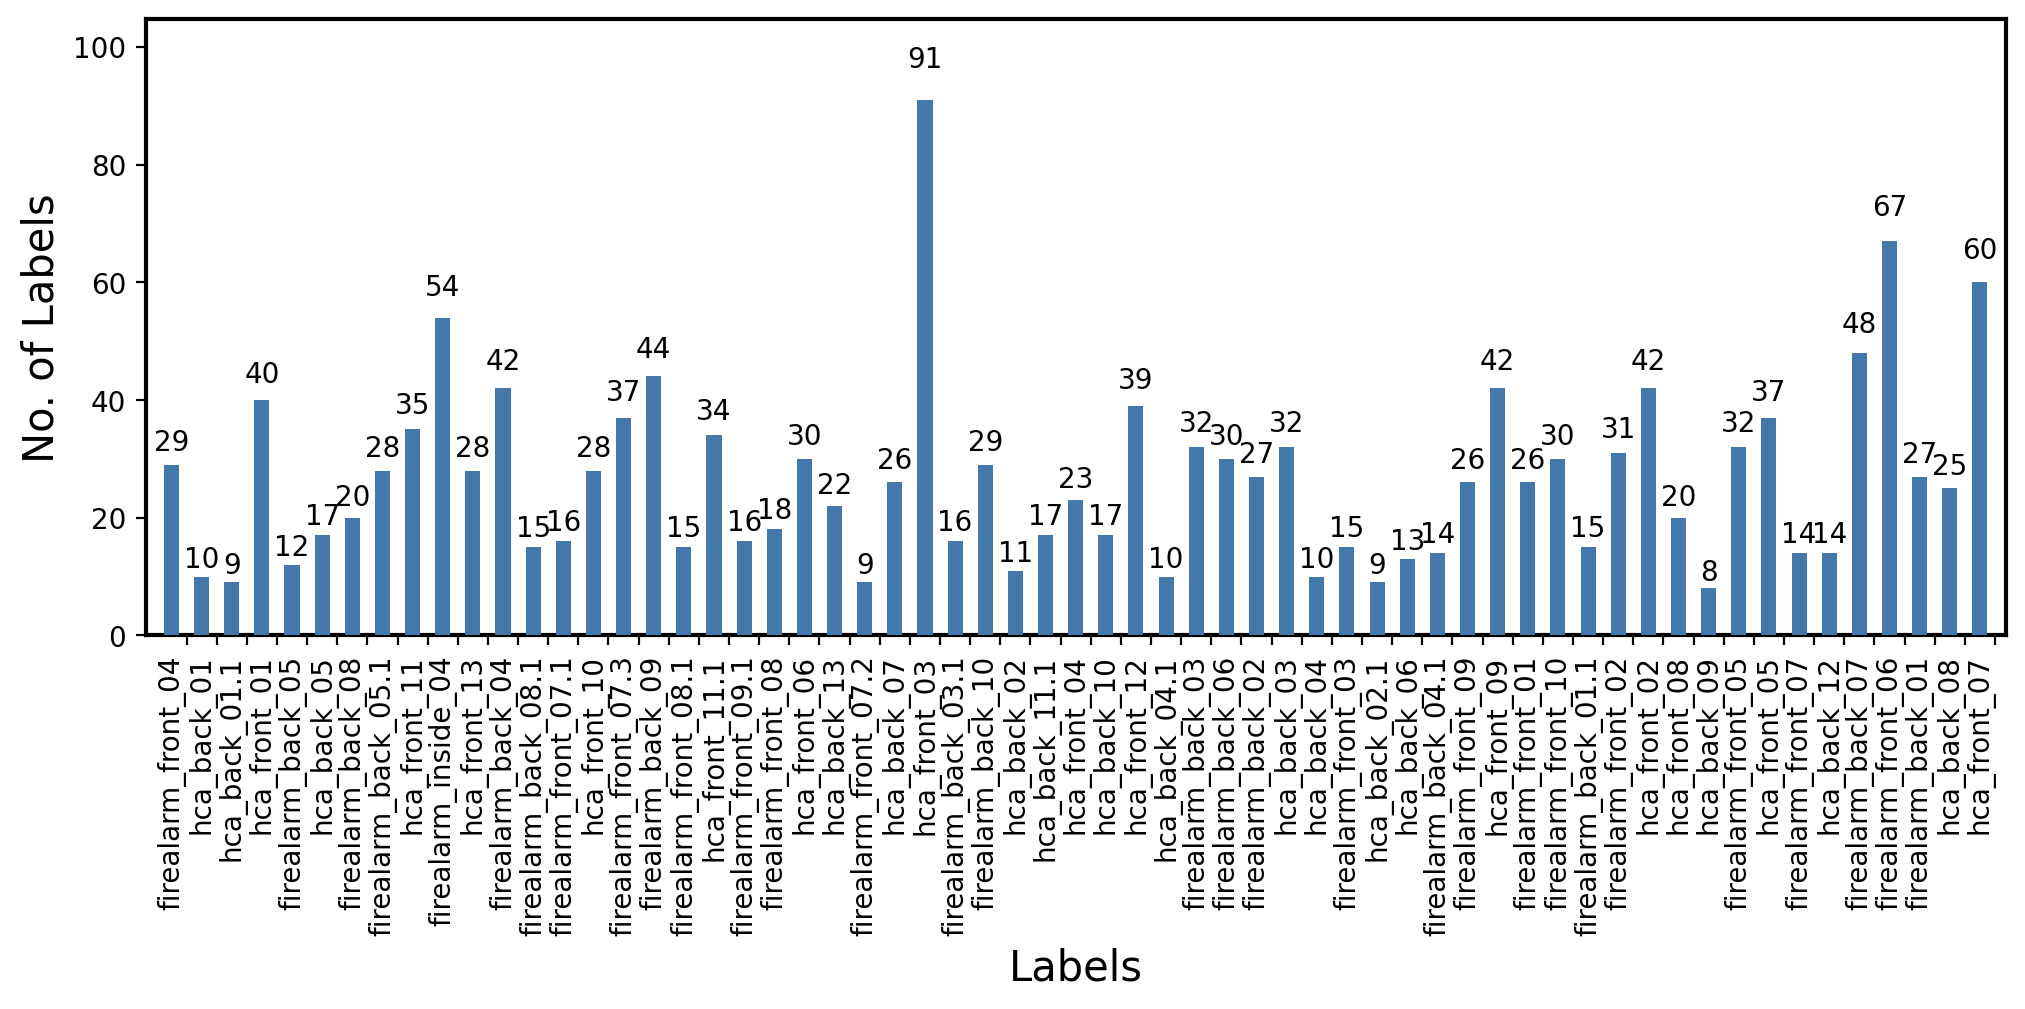

In [39]:
cat1_vals = list(imgs_stats.values())
labels = list(imgs_stats.keys())

plot_barchart(cat1_vals, labels)

# todo: we could sort by device, or something like that

In [ ]:


seen_classes, unseen_classes = random_seen_unseen_class_split(img_path, seen_split=1.0)

print("seen_classes", seen_classes)
print("unseen_classes", unseen_classes)

# seen_classes = ["hca_front_00", "hca_front_01", "hca_front_02", "hca_front_03", "hca_front_04", "hca_front_05", "hca_front_06", "hca_front_07"]
# unseen_classes = ["hca_front_08", "hca_front_09", "hca_front_10", "hca_front_11", "hca_front_12", "hca_front_13", "hca_front_14"]

transform_normalise = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255, always_apply=True)

val_transform = A.Compose([
    A.Resize(300, 300),
    transform_normalise,
    ToTensorV2(),
])

train_transform = A.Compose([
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.25, rotate_limit=45, p=0.5),
        A.OpticalDistortion(p=0.5),
        A.GridDistortion(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.RandomResizedCrop(400, 400, p=0.3),
        A.RGBShift(r_shift_limit=40, g_shift_limit=40, b_shift_limit=40, p=0.5),
        A.RandomBrightnessContrast(p=0.3),

        A.Resize(300, 300),
        transform_normalise,
        ToTensorV2(),
])

dl = DataLoader(img_path,
                seen_classes=seen_classes,
                unseen_classes=unseen_classes,
                train_transform=train_transform,
                val_transform=val_transform,
                cuda=True)

seen_classes
[
    'firealarm_back_01',
    'firealarm_back_01.1',
    'firealarm_back_02',
    'firealarm_back_03',
    'firealarm_back_03.1',
    'firealarm_back_04',
    'firealarm_back_04.1',
    'firealarm_back_05',
    'firealarm_back_05.1',
    'firealarm_back_06',
    'firealarm_back_07',
    'firealarm_back_08',
    'firealarm_back_08.1',
    'firealarm_back_09',
    'firealarm_back_10',
    'firealarm_front_01',
    'firealarm_front_02',
    'firealarm_front_03',
    'firealarm_front_04',
    'firealarm_front_05',
    'firealarm_front_06',
    'firealarm_front_07',
    'firealarm_front_07.1',
    'firealarm_front_07.2',
    'firealarm_front_07.3',
    'firealarm_front_08',
    'firealarm_front_08.1',
    'firealarm_front_09',
    'firealarm_front_09.1',
    'firealarm_front_10',
    'firealarm_inside_04',
    'hca_back_01',
    'hca_back_01.1',
    'hca_back_02',
    'hca_back_02.1',
    'hca_back_03',
    'hca_back_04',
    'hca_back_04.1',
    'hca_back_05',
    'hca_back_06',
    'hca_back_07',
    'hca_back_08',
    'hca_back_09',
    'hca_back_10',
    'hca_back_11.1',
    'hca_back_12',
    'hca_back_13',
    'hca_front_01',
    'hca_front_02',
    'hca_front_03',
    'hca_front_04',
    'hca_front_05',
    'hca_front_06',
    'hca_front_07',
    'hca_front_08',
    'hca_front_09',
    'hca_front_10',
    'hca_front_11',
    'hca_front_11.1',
    'hca_front_12',
    'hca_front_13'
]

unseen_classes
[]

sample.shape
torch.Size([16, 3, 300, 300])

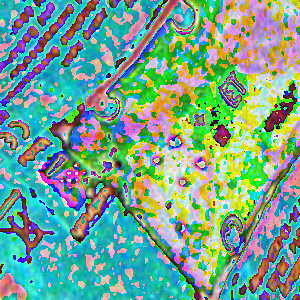

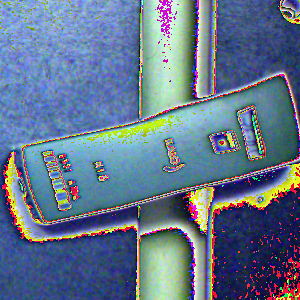

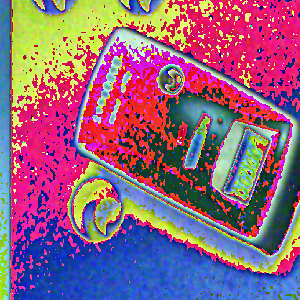

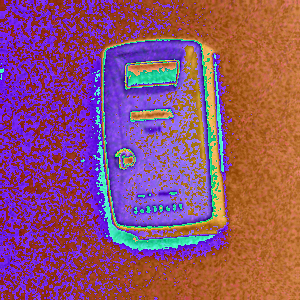

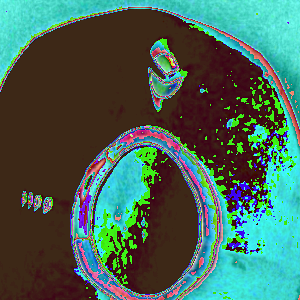

In [ ]:
# if normalise is used in the augmentations, then this will look very funny
for i, batch in enumerate(dl.dataloaders["seen_train"]):
    sample, label, path, _ = batch
    print("sample.shape", sample.shape)
    for j in np.arange(len(sample)):
        pil_img = transforms.ToPILImage()(sample[j])
        display(pil_img)

        if j > 3:
            break

    break

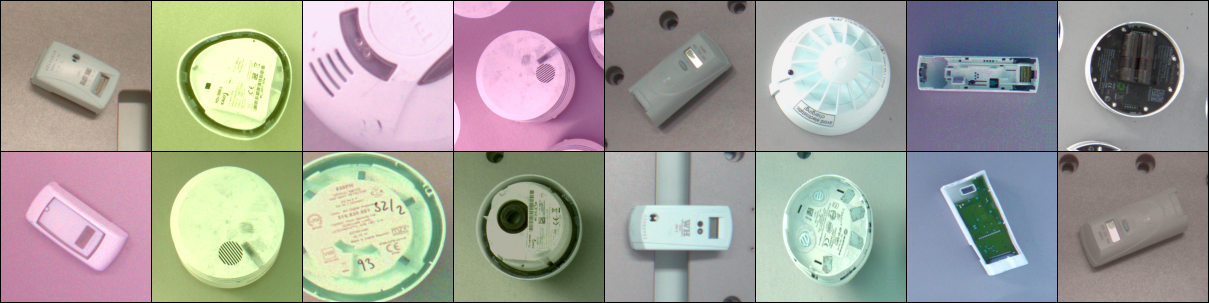

In [ ]:
img_grid = dl.visualise(type_name="seen_train")
display(Image.fromarray(img_grid))
